## Lab 1.2 - Visualize Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. 

### Main objectives
After successful completion of the lab work students will be able to:
-   Analyze datasets with visualization techniques


### 1. Load data with real estate prices

In [1]:
# let's import pandas library and set options to be able to view data right in the browser
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')


In [2]:
# import math library which we'll need later for calculating metrics
import math
from sklearn.metrics import mean_squared_error

In [3]:
# load our dataset and see which data it contains.
spb_df = pd.read_table('spb.real.estate.archive.2018.tsv')

In [4]:
# let's look at random sample of the loaded dataset to understand what's inside
spb_df.sample(5)

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id
331213,3355253944529421151,2018-04-13T00:00:00+03:00,2018-06-14T00:00:00+03:00,25000.0,1,False,2,False,37.0,8.7,25.0,NaN,NaN,2,2,"Россия, Санкт-Петербург, улица Костюшко, 13",357662724425306303
206442,6299725311870770458,2014-11-27T00:00:00+03:00,2018-08-20T00:00:00+03:00,7999000.0,5,False,4,False,85.0,NaN,47.0,NaN,NaN,1,2,"Россия, Санкт-Петербург, Кавалергардская улица, 8",7446159169039951825
385671,7150170334819775754,2018-06-28T00:00:00+03:00,2018-08-20T00:00:00+03:00,38000.0,12,False,2,False,80.0,17.0,40.0,50.0,NaN,2,2,"Россия, Санкт-Петербург, Комендантский проспект, 7к1",8261318597948385731
110656,4350251812774344192,2016-11-24T00:00:00+03:00,2017-01-23T00:00:00+03:00,5650000.0,12,False,1,False,36.0,9.5,16.0,NaN,10.0,1,2,"Россия, Санкт-Петербург, Выборгское шоссе, 15",8120522033915965776
192786,8442286751413134337,2017-07-05T00:00:00+03:00,2017-07-30T00:00:00+03:00,25000.0,24,False,2,False,59.0,9.0,31.0,NaN,11.0,2,2,"Россия, Санкт-Петербург, посёлок Парголово, улица Михаила Дудина, 25к2",4661483057276827066


In [5]:
# let's check how much data to we have
len(spb_df)

429187

### 2. Prepare cleaned dataset with RENT data in St.Peterburg without Oblast 
<p>Use results of our analysis of the previous Lab Works for cleaning the dataset
<p>Reminder: offer_type column contains data to distinct rent from sell items, 2 stands for RENT, 1 for SELL


#### Prepare dataframe with rent data in city limits

In [6]:
rent_df_spb = spb_df[(spb_df.offer_type == 2) & (spb_df.unified_address.str.contains('Россия, Санкт-Петербург'))]

In [7]:
rent_df_spb.head(5)

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id
1086,1100202,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,False,1,False,28.0,8.0,20.0,100.0,3.0,2,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141
1096,5028522699704970725,2015-01-25T00:00:00+03:00,2016-01-20T00:00:00+03:00,40000.0,4,False,2,False,72.0,10.0,44.0,NaN,0.0,2,2,"Россия, Санкт-Петербург, набережная реки Фонтанки, 66",3406104650917898355
1097,5028522699709767236,2015-01-25T00:00:00+03:00,2016-01-21T00:00:00+03:00,45000.0,2,False,2,False,55.0,NaN,33.0,NaN,0.0,2,2,"Россия, Санкт-Петербург, Большой проспект П.С., 102",2357095685903407888
1149,1100874,2015-01-28T00:00:00+03:00,2016-01-16T00:00:00+03:00,21000.0,5,False,1,False,35.0,8.0,18.0,NaN,11.0,2,2,"Россия, Санкт-Петербург, Лужская улица, 8",5887402119500981764
1514,875413,2015-02-13T00:00:00+03:00,2016-01-23T00:00:00+03:00,25000.0,10,False,1,True,44.0,15.0,18.0,90.0,10.0,2,2,"Россия, Санкт-Петербург, Учительская улица, 3",6527910144166454997


#### Calculate price per square meter, get median prices for house and find outliers with the help of this

In [8]:
# calculate price per sq m
rent_df_spb['price_per_sq_m'] = rent_df_spb.last_price/rent_df_spb.area

/tmp/ipykernel_495/1848853247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_spb['price_per_sq_m'] = rent_df_spb.last_price/rent_df_spb.area


##### Find median price per sq m per house

In [9]:
house_rent_df = rent_df_spb.groupby('unified_address').price_per_sq_m.median().reset_index()

In [10]:
house_rent_df.rename(columns = {'price_per_sq_m': 'house_price_sqm_median'}, inplace = True)

In [11]:
house_rent_df.head(5)

,unified_address,house_price_sqm_median
0,"Россия, Санкт-Петербург, 1-й Муринский проспект, 11",571.383648
1,"Россия, Санкт-Петербург, 1-й Муринский проспект, 13",500.000000
2,"Россия, Санкт-Петербург, 1-й Муринский проспект, 15",569.743935
3,"Россия, Санкт-Петербург, 1-й Муринский проспект, 17",600.000000
4,"Россия, Санкт-Петербург, 1-й Муринский проспект, 19",482.142857


##### Merge rent data with house median prices and inspect outliers

In [12]:
rent_df_spb = rent_df_spb.merge(house_rent_df)

##### Clean data from the outliers - use results from Lab 1

In [13]:
rent_df_cleaned = rent_df_spb[~((rent_df_spb.price_per_sq_m/rent_df_spb.house_price_sqm_median) > 5)]
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned.last_price < 1000000]
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m > 3000) 
                                     & ((rent_df_cleaned.house_price_sqm_median < 1000) 
                                        | (rent_df_cleaned.house_price_sqm_median == rent_df_cleaned.price_per_sq_m)))]
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m < 250) 
                               & (rent_df_cleaned.house_price_sqm_median/rent_df_cleaned.price_per_sq_m >= 2))]
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m < 200) 
                                          & (rent_df_cleaned.price_per_sq_m == rent_df_cleaned.house_price_sqm_median))]

#### Visualize 'last_price feature with box plot and violin plot. Explore box plot and clean data following statistical rules and interquartile range

<AxesSubplot: xlabel='last_price'>

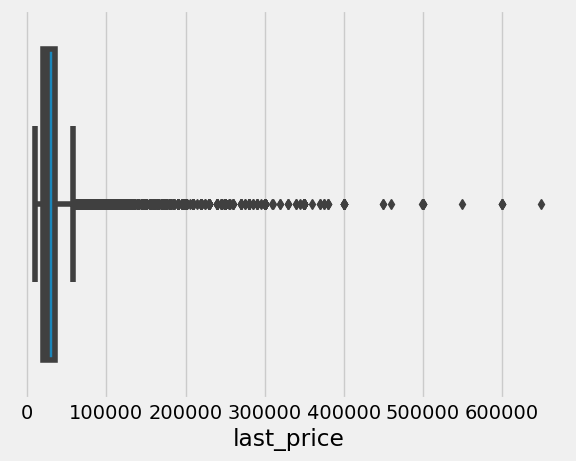

In [14]:
sns.boxplot(data=rent_df_cleaned, x="last_price")

<AxesSubplot: xlabel='last_price'>

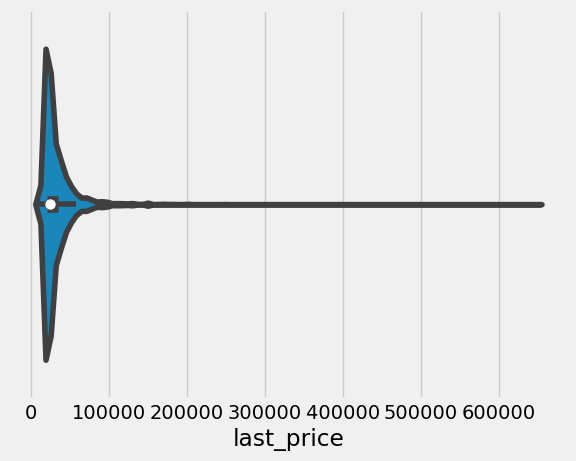

In [15]:
sns.violinplot(data=rent_df_cleaned, x="last_price")

<AxesSubplot: xlabel='last_price', ylabel='Count'>

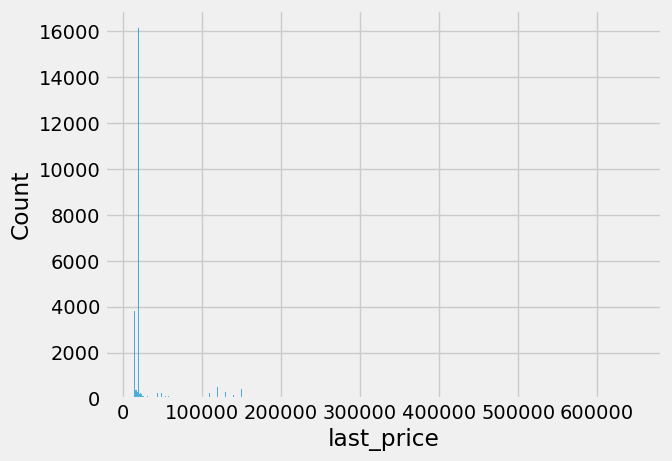

In [16]:
sns.histplot(data=rent_df_cleaned, x="last_price")

In [17]:
def visualize_property (df, feature):
    fig, axs = plt.subplots(1, figsize = (8,5))
    #Histogram
    axs[0].set_title('Histogram')
    df[feature].hist(ax = axs[0])
    #QQ
    #axs[1].set_title('QQ')
    #df[feature].probplot(ax = axs[1])
    #Boxplot
    #axs[1].set_title('Box plot')
    #sns.boxplot(df[feature].hist(ax = axs[1]))
    print("Skewness: %f" % df[feature].skew())
    print("Kurtosis: %f" % df[feature].kurt())

TypeError: 'AxesSubplot' object is not subscriptable

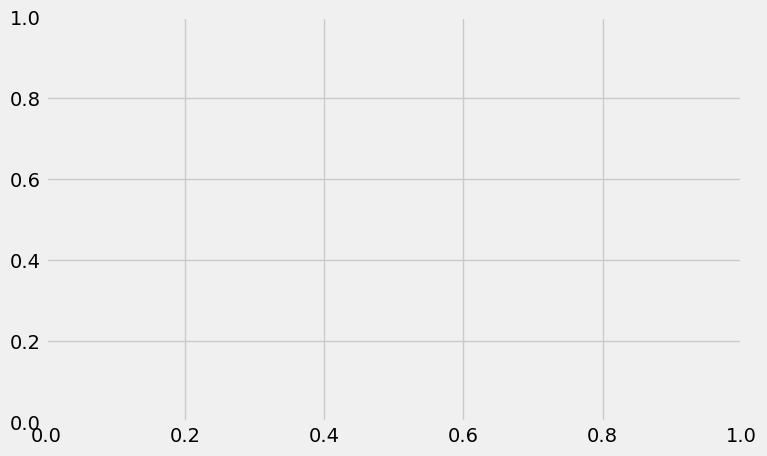

In [18]:
visualize_property(rent_df_cleaned,'last_price')

In [19]:
rent_df_cleaned['last_price'].quantile(0.997)

200000.0

In [20]:
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned['last_price']<200000]

In [21]:
rent_df_cleaned.shape

(155392, 19)

<AxesSubplot: xlabel='last_price', ylabel='Count'>

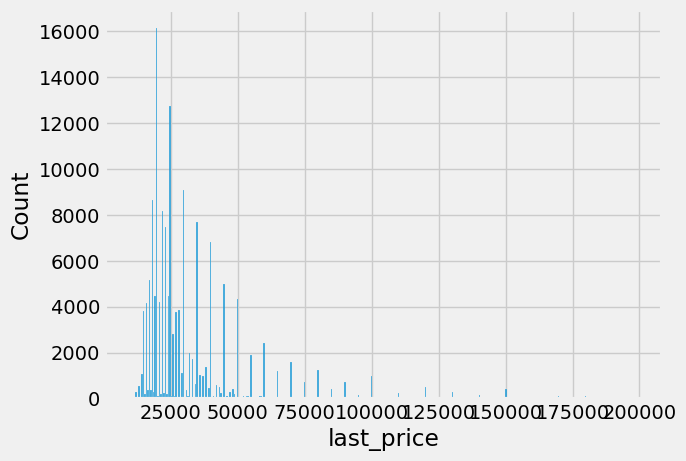

In [22]:
sns.histplot(data=rent_df_cleaned, x="last_price")

As we see, the target variable last_price is not normally distributed.
This can reduce the performance of the ML regression models because some assume normal distribution,
see sklearn info on preprocessing
Therfore we make a log transformation, the resulting distribution looks much better.

In [23]:
rent_df_cleaned['last_price_log'] = np.log(rent_df_cleaned['last_price'])

/tmp/ipykernel_495/4126280238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned['last_price_log'] = np.log(rent_df_cleaned['last_price'])


<AxesSubplot: xlabel='last_price'>

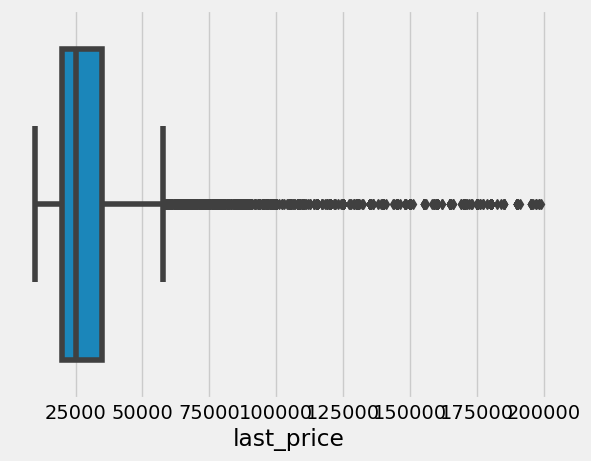

In [24]:
sns.boxplot(data=rent_df_cleaned, x="last_price")

<AxesSubplot: xlabel='last_price_log', ylabel='Count'>

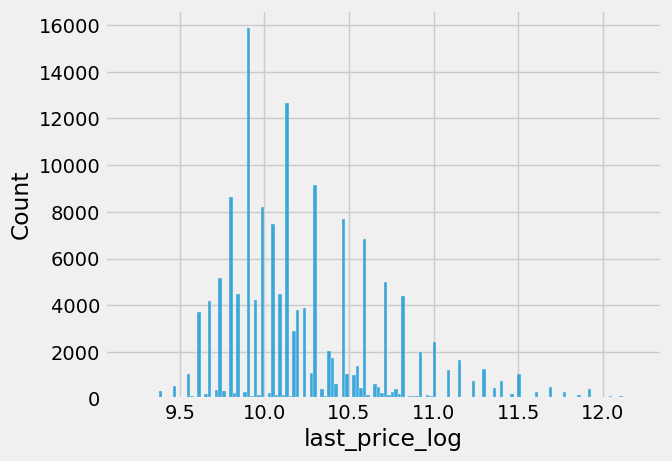

In [25]:
sns.histplot(data=rent_df_cleaned, x="last_price_log")

### Explore features, which of them are binary, which quantitative, qualitative. 

In [26]:
rent_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155392 entries, 0 to 156053
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_id                155392 non-null  int64  
 1   first_day_exposition    155392 non-null  object 
 2   last_day_exposition     155392 non-null  object 
 3   last_price              155392 non-null  float64
 4   floor                   155392 non-null  int64  
 5   open_plan               155392 non-null  bool   
 6   rooms                   155392 non-null  int64  
 7   studio                  155392 non-null  bool   
 8   area                    155392 non-null  float64
 9   kitchen_area            118364 non-null  float64
 10  living_area             123015 non-null  float64
 11  agent_fee               122840 non-null  float64
 12  renovation              102677 non-null  float64
 13  offer_type              155392 non-null  int64  
 14  category_type       

In [27]:
binary = [f for f in rent_df_cleaned.columns if rent_df_cleaned.dtypes[f] == 'bool']
print ("Binary variables: {}".format(binary))
quantitative = [f for f in rent_df_cleaned.columns if rent_df_cleaned.dtypes[f] != 'object']
for f in binary:
    quantitative.remove(f)
print ("Quantitative variables: {}".format(quantitative))
qualitative = [f for f in rent_df_cleaned.columns if rent_df_cleaned.dtypes[f] == 'object']
print ("Qualitative variables: {}".format(qualitative))

Binary variables: ['open_plan', 'studio']
Quantitative variables: ['offer_id', 'last_price', 'floor', 'rooms', 'area', 'kitchen_area', 'living_area', 'agent_fee', 'renovation', 'offer_type', 'category_type', 'building_id', 'price_per_sq_m', 'house_price_sqm_median', 'last_price_log']
Qualitative variables: ['first_day_exposition', 'last_day_exposition', 'unified_address']


## Find missing values fill them as you want. 

<AxesSubplot: >

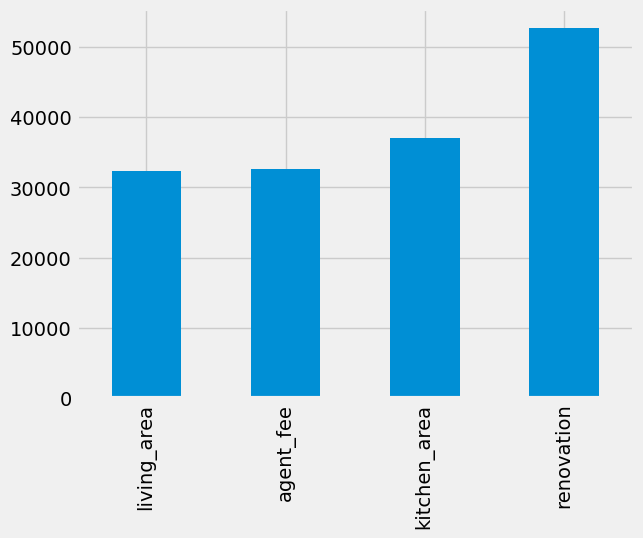

In [28]:
missing = rent_df_cleaned.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [29]:
rent_df_cleaned[rent_df_cleaned['living_area'].isnull()].head()

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id,price_per_sq_m,house_price_sqm_median,last_price_log
8,4181888598340999168,2018-01-05T00:00:00+03:00,2018-01-16T00:00:00+03:00,26000.0,12,False,1,False,36.0,NaN,NaN,NaN,NaN,2,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,722.222222,512.820513,10.165852
26,1166248862458040064,2018-03-19T00:00:00+03:00,2018-04-18T00:00:00+03:00,22000.0,12,False,1,False,32.0,NaN,NaN,NaN,NaN,2,2,"Россия, Санкт-Петербург, Лужская улица, 8",5887402119500981764,687.500000,568.468556,9.998798
29,5153793897333863110,2018-03-28T00:00:00+03:00,2018-04-02T00:00:00+03:00,19000.0,7,False,1,False,35.0,8.0,NaN,99.0,NaN,2,2,"Россия, Санкт-Петербург, Лужская улица, 8",5887402119500981764,542.857143,568.468556,9.852194
41,6720278181597658625,2017-01-30T00:00:00+03:00,2017-01-30T00:00:00+03:00,65000.0,14,False,3,False,110.0,NaN,NaN,60.0,0.0,2,2,"Россия, Санкт-Петербург, Морская набережная, 37к2",1756484481996641220,590.909091,584.117647,11.082143
48,3376106655955437495,2016-12-14T00:00:00+03:00,2017-05-24T00:00:00+03:00,70000.0,7,False,3,False,160.0,30.0,NaN,100.0,0.0,2,2,"Россия, Санкт-Петербург, Морская набережная, 37к2",1756484481996641220,437.500000,584.117647,11.156251


In [30]:
rent_df_cleaned['offer_type'].value_counts()

2    155392
Name: offer_type, dtype: int64

In [31]:
rent_df_cleaned['category_type'].value_counts()

2    155392
Name: category_type, dtype: int64

In [32]:
rent_df_cleaned['renovation'].fillna(0.0, inplace=True)

/tmp/ipykernel_495/2129742408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned['renovation'].fillna(0.0, inplace=True)


### Drop useless columns

In [33]:
rent_df_cleaned.drop(columns=['offer_type','category_type','agent_fee'], inplace = True)

/tmp/ipykernel_495/619266528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned.drop(columns=['offer_type','category_type','agent_fee'], inplace = True)


In [34]:
rent_df_cleaned.head(5)

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,unified_address,building_id,price_per_sq_m,house_price_sqm_median,last_price_log
0,1100202,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,False,1,False,28.0,8.0,20.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,714.285714,512.820513,9.903488
1,4593125,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,False,2,False,59.0,10.0,35.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,406.779661,512.820513,10.085809
2,4586184,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,False,1,False,36.0,9.0,17.0,3.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,500.000000,512.820513,9.798127
3,5308071,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,False,1,False,39.0,10.0,18.0,0.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,461.538462,512.820513,9.798127
4,7534283612538021121,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,False,1,False,36.0,8.0,18.0,11.0,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,527.777778,512.820513,9.852194


<AxesSubplot: >

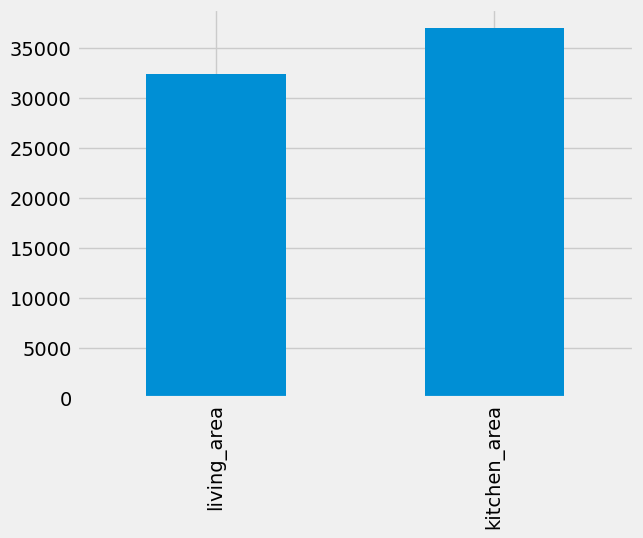

In [35]:
missing = rent_df_cleaned.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

### Explore relations between different features. Build correlation heatmap

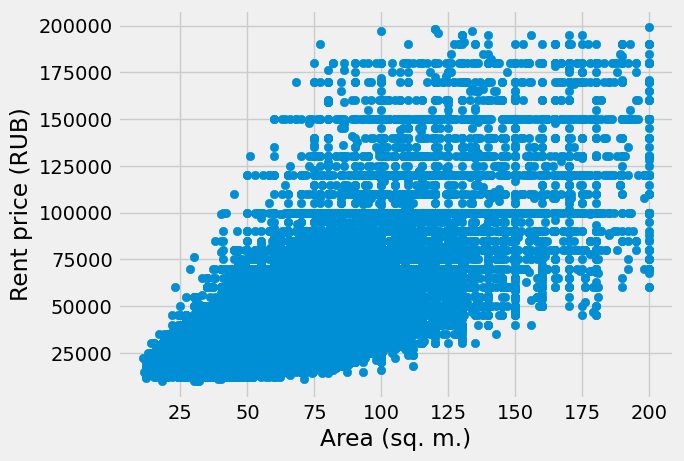

In [36]:
#let's see if there is a relationship between the rent price and the size of the apartment
plt.scatter(rent_df_cleaned['area'], rent_df_cleaned['last_price'])
plt.xlabel('Area (sq. m.)')
plt.ylabel('Rent price (RUB)')
plt.show()

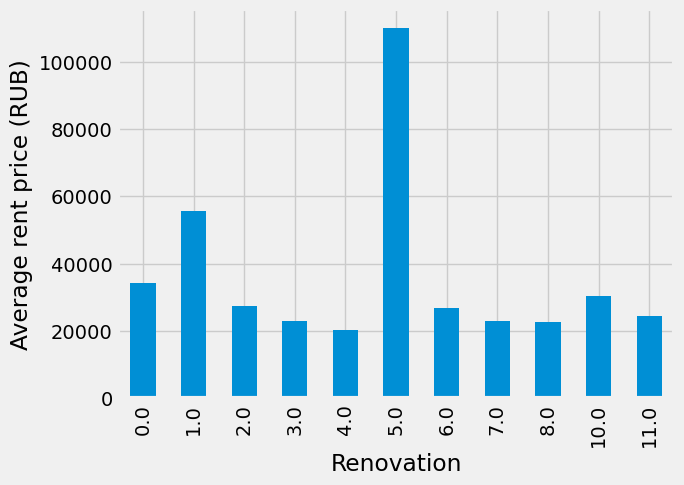

In [37]:
#let's see how the rent price varies depending on the renovation status of the apartment
rent_df_cleaned.groupby('renovation')['last_price'].mean().plot.bar()
plt.xlabel('Renovation')
plt.ylabel('Average rent price (RUB)')
plt.show()

/tmp/ipykernel_495/3387388967.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = rent_df_cleaned.corr()


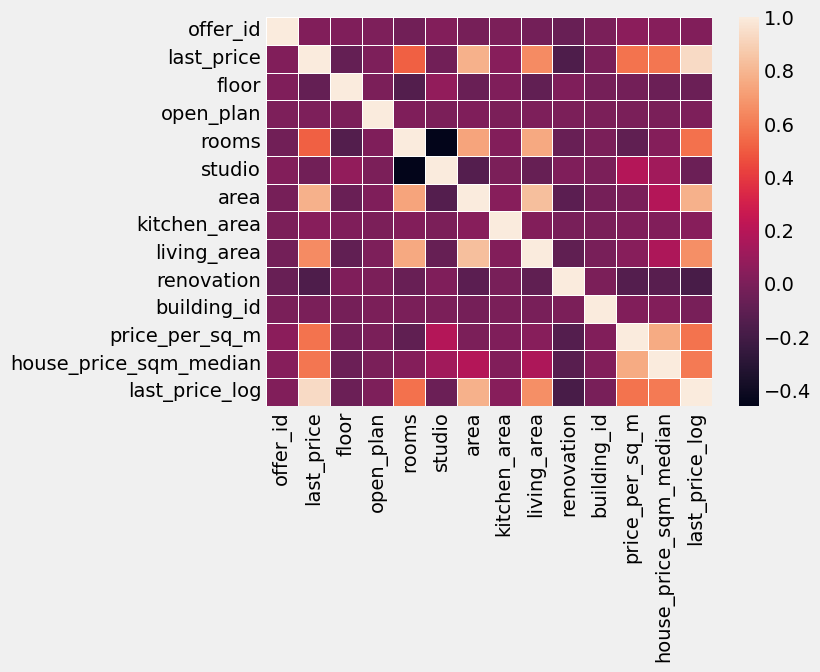

In [38]:
corr = rent_df_cleaned.corr()
sns.heatmap(corr, linewidth=.5)
plt.show()


#corr = rent_df_cleaned.corr()
#sns.heatmap(corr, annot=True, annot_kws={"fontsize": 8}, cbar_kws={"fontsize": 8})
#plt.show()


#### Save cleaned dataset to new csv.

In [39]:
rent_df_cleaned.to_csv('rent_df_cleaned.csv', index=False, header=True)

### Self-control stops
1. How do You think which feature is most important in predicting price. 
2. What other factors might influence price? Think of the factors which can be actually calculated and included in the model. Maybe from some external sources? 

1)The most important feature in predicting the price of an apartment is probably the area of the apartment. The area is a direct measure of the size of the apartment, which is one of the most important factors that buyers consider when purchasing an apartment.

2) Other factors that might influence price:
1. Location: The location of the apartment is a major factor in determining its price. Apartments in desirable locations, such as near city centers or in popular neighborhoods, will typically sell for more than apartments in less desirable locations. We can get this data from the adress and using openstreetmap. 
2. Condition of the Property: Age of the building.
3. Size: Number of rooms.
4. Floor Level: Properties on higher floors usually have higher demand and prices.
5. Furnishing: Fully furnished properties may command higher rents.
6. Utilities: Inclusion or exclusion of utilities in the rent price.
7. Pet Policy: Whether pets are allowed or not can impact the rental price.
8. Amenities and other cultural objects nearby can influence the price.